In [69]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings

from Generating_Feature_Importance_tuning_PCA_model import PCA_My_Airbnb_Capstone_Model, PCA_pre_processing_pipeline
from Generating_Feature_Importance_tuning_raw_feature_model import My_Airbnb_Capstone_Model, pre_processing_pipeline
from scipy.stats import spearmanr
def spearmanr_score(truth, pred):
        return spearmanr(truth, pred)[0]
model1 = pickle.load(open('./Feature_Importance_tuning_raw_feature_model.pkl','rb'))
model2 = pickle.load(open('./Feature_Importance_tuning_PCA_model.pkl','rb'))


In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### read features
data = pd.read_csv('./final_features/LA_extracted_all_features_imputed.csv')

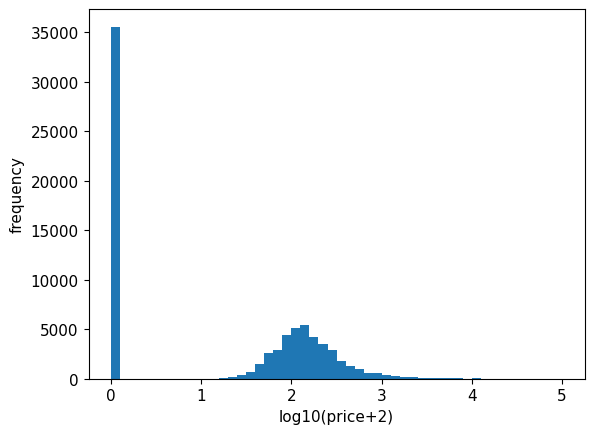

In [43]:
plt.hist(np.log10(data.price+2),bins=50)
plt.xlabel('log10(price+2)')
plt.ylabel('frequency')
plt.savefig('log_price_2.png',dpi=500)
plt.show()

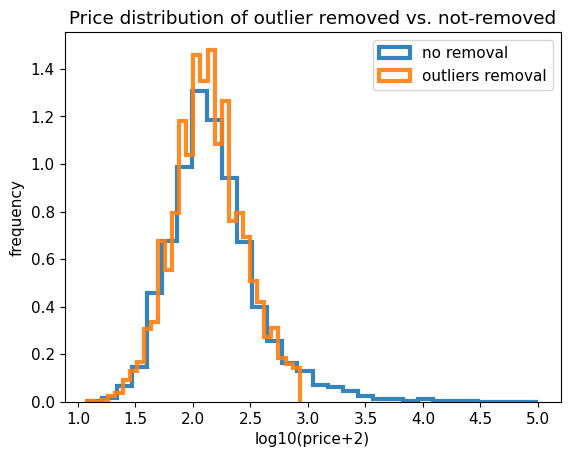

In [57]:
plt.hist(np.log10(data[data.price>0].price+2),bins=30,label='no removal',density=True, fill=False, histtype='step',linewidth=3,alpha=0.9)
data1 = data[data.price>0][
    (np.log(data['price']+1)>=sorted(np.log(data['price']+1))[int(0.025*len(data))]) &\
    (np.log(data['price']+1)<=sorted(np.log(data['price']+1))[int(0.975*len(data))])
    ] ### remove outliers
plt.hist(np.log10(data1.price+2),bins=30,label='outliers removal',density=True, fill=False, histtype='step',linewidth=3,alpha=0.9)
plt.xlabel('log10(price+2)')
plt.ylabel('frequency')
plt.title('Price distribution of outlier removed vs. not-removed')
plt.legend()
plt.savefig('hist_of_price_outliers.png',dpi=500)
plt.show()

1. only remove negatives and zeros

In [6]:

### define model
model1 = My_Airbnb_Capstone_Model()
### get X,y
X1, y1 = model1.get_X_y(data, outlier_removal=False)




Filling infinite values with -1 ...

Amenities raw features count: 174
Location raw features count: 28
Image raw features count: 617
NLP raw features count: 994


X shape: (37424, 1813)
y shape: (37424,)



In [8]:
for n in X1.columns:
    if '>' in n or '<' in n or ',' in n:
        del X1[n]

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMRegressor
scores1 = cross_validate(LGBMRegressor(random_state=42,objective='quantile', 
                                            alpha=0.5,learning_rate=0.2,max_depth=7,num_leaves=48), 
                         X1, y1, cv=5, scoring='neg_mean_squared_error')


In [26]:
scores1['test_score']

array([-2.6733e+05, -1.0917e+06, -7.2106e+05, -1.4215e+06, -2.4174e+06])

2. remove negatives, zeros, and then remove lower 0.025 and upper 0.975

In [15]:
### define model
model2 = My_Airbnb_Capstone_Model()
### get X,y
X2, y2 = model1.get_X_y(data, outlier_removal=True)



Filling infinite values with -1 ...

Amenities raw features count: 174
Location raw features count: 28
Image raw features count: 617
NLP raw features count: 994


X shape: (36659, 1813)
y shape: (36659,)



In [23]:
for n in X2.columns:
    if '>' in n or '<' in n or ',' in n:
        del X2[n]

In [24]:
### training
scores2 = cross_validate(LGBMRegressor(random_state=42,objective='quantile', 
                                            alpha=0.5,learning_rate=0.2,max_depth=7,num_leaves=48), 
                         X2, y2, cv=5, scoring='neg_mean_squared_error')


In [27]:
scores2['test_score']

array([     -21266,      -25070,      -26766,      -41174,      -39319])

In [31]:
%matplotlib inline

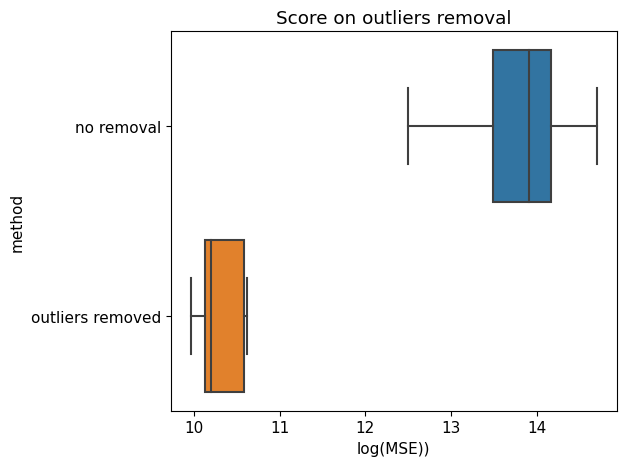

In [64]:
# plt.figure
res = pd.DataFrame({
    'method':['no removal' for i in range(5)] + ['outliers removed' for i in range(5)],
    'MSE':np.log(list(-scores1['test_score']) + list(-scores2['test_score']))
})
sns.boxplot(data=res,x='MSE',y='method')
plt.xlabel('log(MSE))')
plt.title('Score on outliers removal')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('outlier_removal.png',dpi=500)
plt.show()


In [41]:
from scipy.stats import ranksums
ranksums(res[res.method=='no removal'].MSE,
         res[res.method=='outliers removal removal'].MSE)

RanksumsResult(statistic=2.6111648393354674, pvalue=0.009023438818080326)

In [67]:
### read features
data = pd.read_csv('./final_features/LA_extracted_all_features_imputed.csv')
data = data[data.price>0][
    (np.log(data['price']+1)>=sorted(np.log(data['price']+1))[int(0.025*len(data))]) &\
    (np.log(data['price']+1)<=sorted(np.log(data['price']+1))[int(0.975*len(data))])
    ] ### remove outliers

### define model
model = model1

### get X,y
X, y = model.get_X_y(data)





Filling infinite values with -1 ...

Amenities raw features count: 174
Location raw features count: 28
Image raw features count: 617
NLP raw features count: 994


X shape: (35525, 1813)
y shape: (35525,)



In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
import shap
# plt.figure(figsize=(15,15))
explainer = shap.Explainer(model1.model_for_shap[1])
shap_values = explainer(X[model1.x_names])
# shap.plots.beeswarm(shap_values,max_display=15,show=False)
# plt.title('Feature importances for full-feature model')
# plt.tight_layout()
# plt.savefig('Feature_importance_full_feature.png',dpi=500)


<Figure size 1500x1500 with 0 Axes>

In [76]:
shap_values.values.shape

(35525, 1810)

In [89]:
amenities_f_list = [i for i in model1.x_names if i.startswith('Amenities')] ### starts with 'Amenities'
location_f_list = [i for i in model1.x_names if i.startswith('Location')]
image_f_list = [i for i in model1.x_names if i.startswith('Image')]
NLP_f_list = [i for i in model1.x_names if i.startswith('NLP')]

(35525,)

In [99]:
plt.hist(shap_values.values[:,[model1.x_names.index(i) for i in amenities_f_list]].sum(axis=1),
         #density=True, 
         fill=False, histtype='step',linewidth=3,alpha=0.9, label='amenities')
plt.hist(shap_values.values[:,[model1.x_names.index(i) for i in location_f_list]].sum(axis=1),
         #density=True, 
         fill=False, histtype='step',linewidth=3,alpha=0.9,label='locaiton')
plt.hist(shap_values.values[:,[model1.x_names.index(i) for i in image_f_list]].sum(axis=1),
         #density=True, 
         fill=False, histtype='step',linewidth=3,alpha=0.9,label='image')
plt.hist(shap_values.values[:,[model1.x_names.index(i) for i in NLP_f_list]].sum(axis=1),
         #density=True, 
         fill=False, histtype='step',linewidth=3,alpha=0.9,label='description')
plt.legend()
plt.title('Historgram of impact of different feature categories on pricing')
plt.xlabel('SHAP value')
plt.ylabel('frequency')
plt.savefig('Freature_importance_by_categories.png',dpi=500)
plt.show()

In [ ]:
shap_values.values

In [72]:
model.pipeline_dict

{}

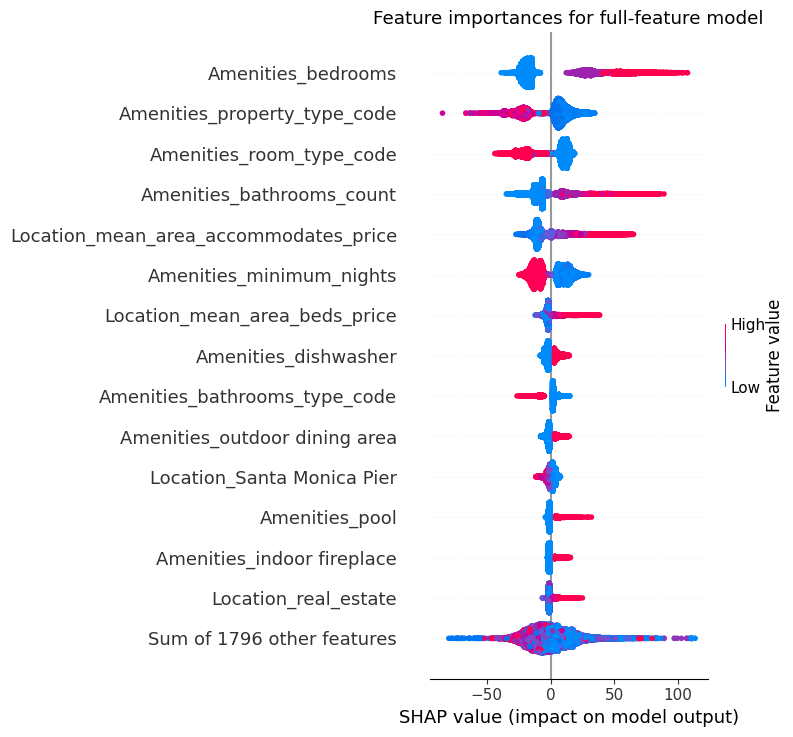

In [26]:
import shap
plt.figure(figsize=(15,15))
explainer = shap.Explainer(model.model_for_shap[1])
shap_values = explainer(X[model.x_names])
shap.plots.beeswarm(shap_values,max_display=15,show=False)
plt.title('Feature importances for full-feature model')
plt.tight_layout()
plt.savefig('Feature_importance_full_feature.png',dpi=500)


In [54]:
# model.

-4625.226302047092

In [31]:
pred = model.predict(X[model.x_names])

In [36]:
y.shape, pred[0.5].shape

((34827,), (34827,))

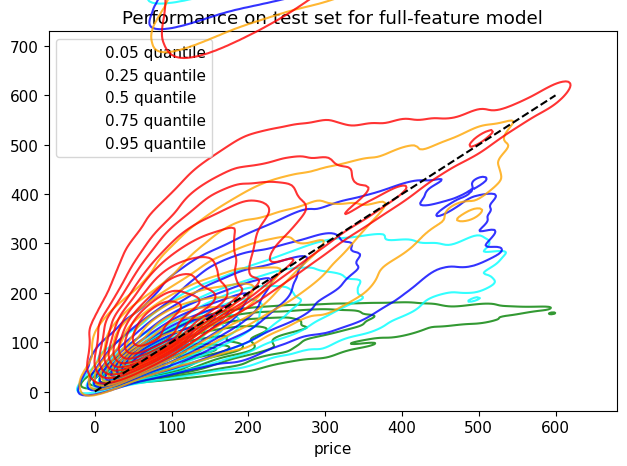

In [55]:
sns.kdeplot(
    x=y,
    y=pred[0.05],color='green',alpha=0.8,label='0.05 quantile'
)

sns.kdeplot(
    x=y,
    y=pred[0.25],color='cyan',alpha=0.8,label='0.25 quantile'
)

sns.kdeplot(
    x=y,
    y=pred[0.5],color='blue',alpha=0.8,label='0.5 quantile'
)

sns.kdeplot(
    x=y,
    y=pred[0.75],color='orange',alpha=0.8,label='0.75 quantile'
)


sns.kdeplot(
    x=y,
    y=pred[0.95],color='red',alpha=0.8,label='0.95 quantile'
)

plt.plot(
    [0,600],
    [0,600],linestyle='dashed',color='black'
)

plt.title('Performance on test set for full-feature model')
plt.legend()
plt.tight_layout()
plt.savefig('Performance_full_feature.png',dpi=500)



In [37]:
a = pd.DataFrame({
    'y':list(y.values) * 5,
    'pred':list(pred[0.05]) + list(pred[0.25]) + list(pred[0.5]) + list(pred[0.75]) + list(pred[0.95]),
    'quantile':['0.05' for i in range(len(pred[0.05]))] + ['0.25' for i in range(len(pred[0.05]))] + ['0.5' for i in range(len(pred[0.05]))] + \
        ['0.75' for i in range(len(pred[0.05]))] + ['0.95' for i in range(len(pred[0.05]))]
})

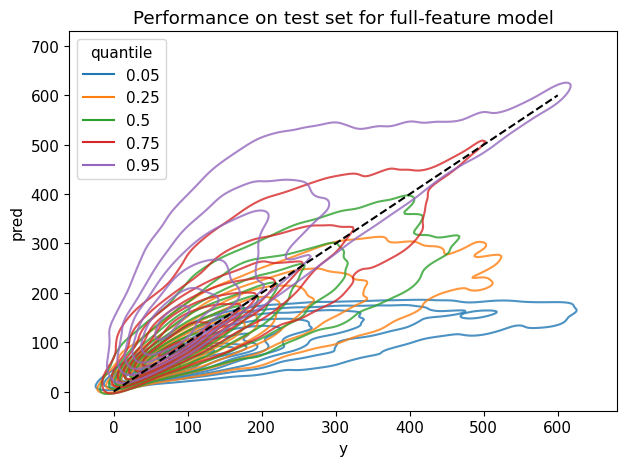

In [39]:
sns.kdeplot(
    data=a,
    x='y',
    y='pred',hue='quantile',alpha=0.8, legend=True
)

plt.plot(
    [0,600],
    [0,600],linestyle='dashed',color='black'
)

plt.title('Performance on test set for full-feature model')
plt.tight_layout()
plt.savefig('Performance_full_feature.png',dpi=500)



In [95]:
ME = pd.DataFrame(
    pred[0.5] - y
)


In [114]:
# visualize the first prediction's explanation with a force plot
import shap

#### 1) over estimate
explainer = shap.Explainer(model.pipeline_dict[0.5][1])
shap_values = explainer(X.loc[np.array(ME>100),:][model.x_names])

l = []
for i in shap_values:
    shap_dict= dict(
            zip(
                i.feature_names,
                i.values
            )
        )
    l.append(shap_dict)
over_estimate_df = pd.DataFrame(l)

#### 2) good estimate
explainer = shap.Explainer(model.pipeline_dict[0.5][1])
shap_values = explainer(X.loc[np.array(ME<100) & np.array(ME>-100),:][model.x_names])

l = []
for i in shap_values:
    shap_dict= dict(
            zip(
                i.feature_names,
                i.values
            )
        )
    l.append(shap_dict)
good_estimate_df = pd.DataFrame(l)


#### 3) under estimate
explainer = shap.Explainer(model.pipeline_dict[0.5][1])
shap_values = explainer(X.loc[np.array(ME<-100),:][model.x_names])

l = []
for i in shap_values:
    shap_dict= dict(
            zip(
                i.feature_names,
                i.values
            )
        )
    l.append(shap_dict)
under_estimate_df = pd.DataFrame(l)




In [147]:
over_estimate_df

,Amenities_bedrooms,Amenities_beds,Amenities_minimum_nights,Amenities_maximum_nights,Amenities_property_type_code,...,Image_teddy bear,Image_hair drier,Image_toothbrush,Image_mean_mean_min_dist_r3,Image_mean_mean_weighted_min_dist_r3
0,40.743773,0.066442,-14.276142,0.054390,25.743603,...,0.0,0.0,0.0,-0.003607,0.000091
1,52.418921,-0.060042,-14.572971,0.111018,3.388915,...,0.0,0.0,0.0,0.004548,-0.000371
2,26.239341,0.103538,18.878863,0.419868,15.381210,...,0.0,0.0,0.0,0.003239,0.000091
3,32.816445,-0.272301,-13.896456,-0.027665,15.879225,...,0.0,0.0,0.0,-0.006861,-0.000371
4,63.865830,-0.229776,12.308594,0.079983,29.003985,...,0.0,0.0,0.0,0.032820,-0.000371
...,...,...,...,...,...,...,...,...,...,...,...
499,35.547004,0.110728,-9.431575,0.037779,12.687759,...,0.0,0.0,0.0,0.008150,0.000091
500,91.835119,-0.080299,-8.031459,0.032117,23.649328,...,0.0,0.0,0.0,0.005826,0.000091
501,64.202923,-0.202863,-11.419112,-0.160755,12.962632,...,0.0,0.0,0.0,0.008150,0.000152
502,46.721641,-0.037952,6.493422,0.131714,-50.659812,...,0.0,0.0,0.0,0.005826,0.000091


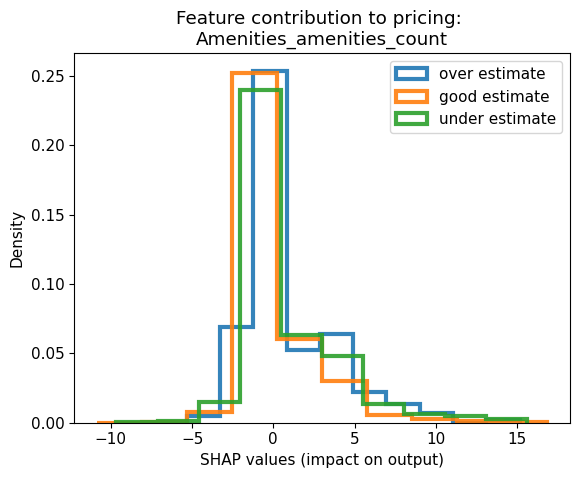

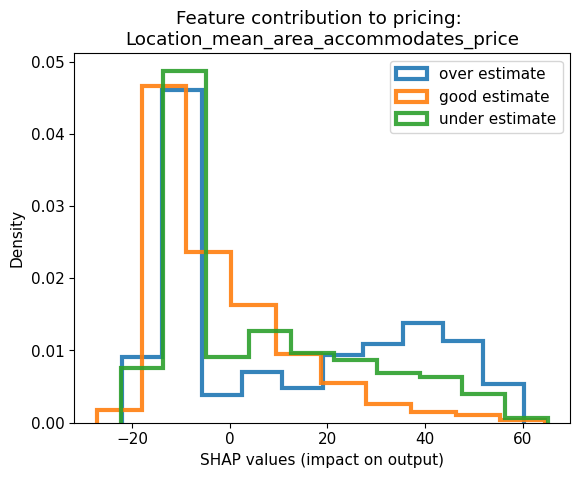

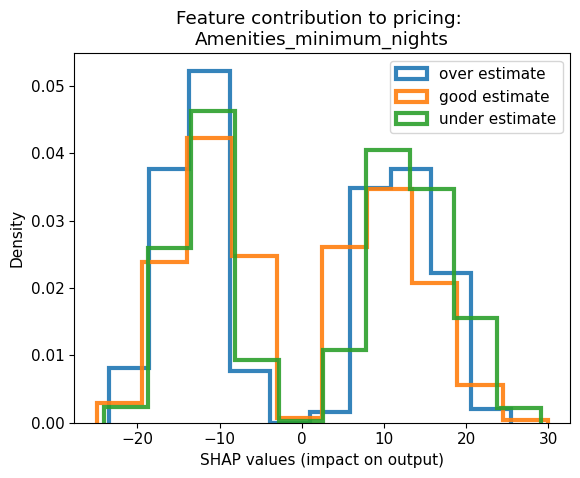

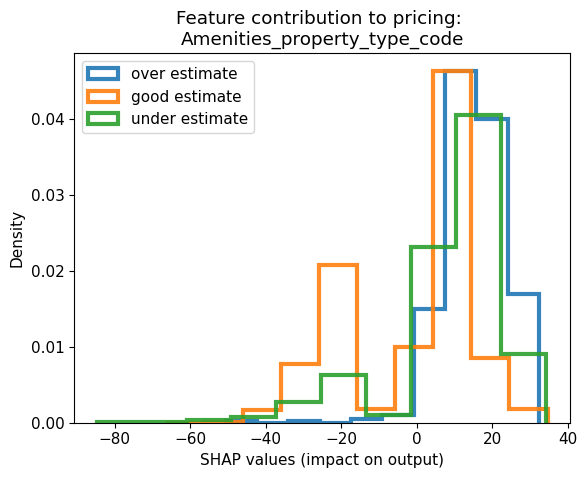

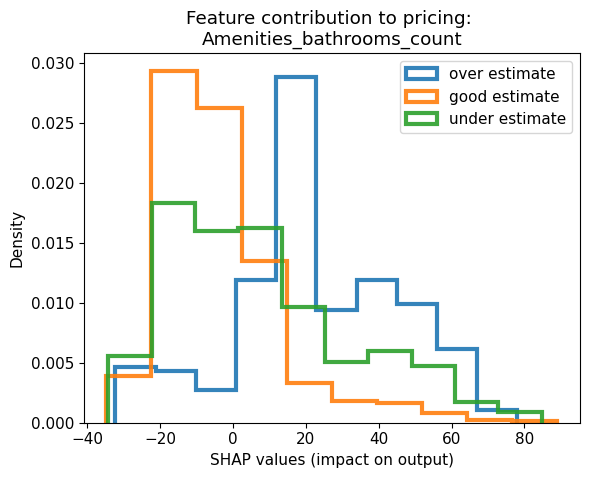

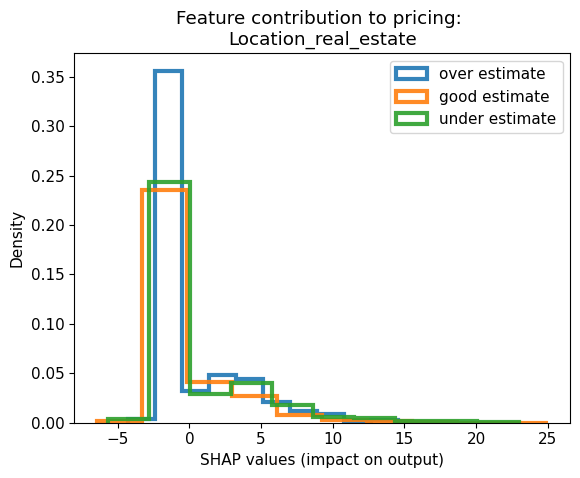

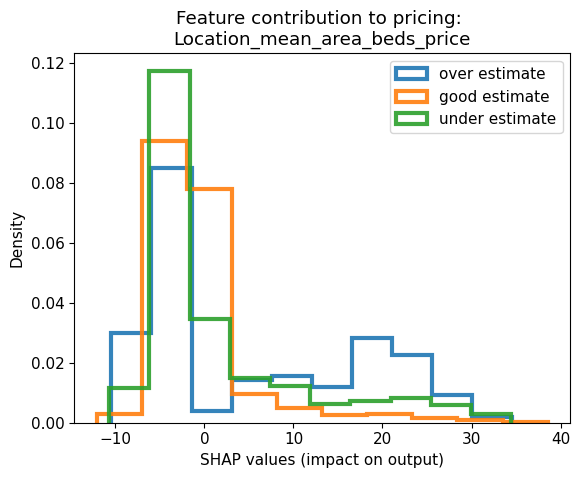

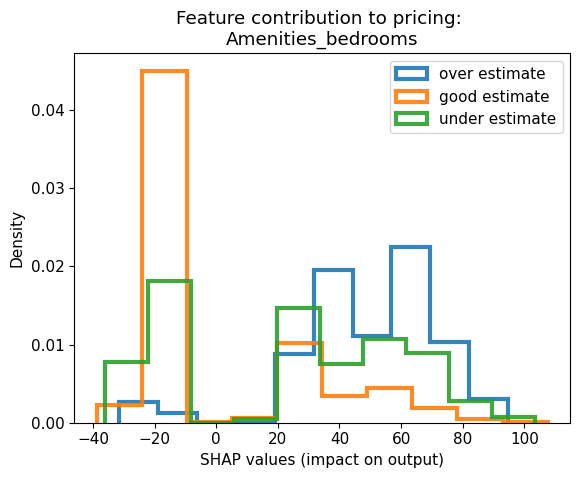

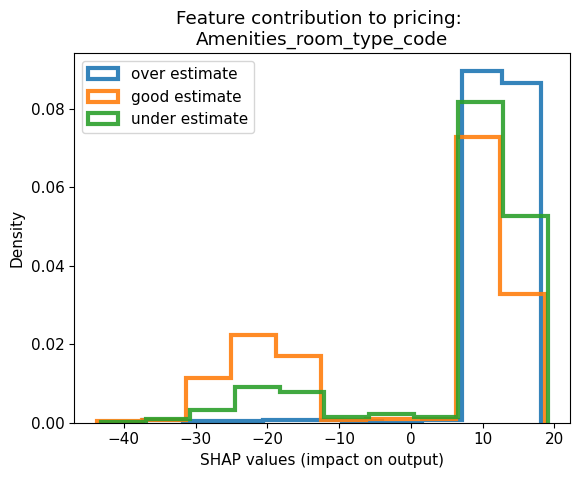

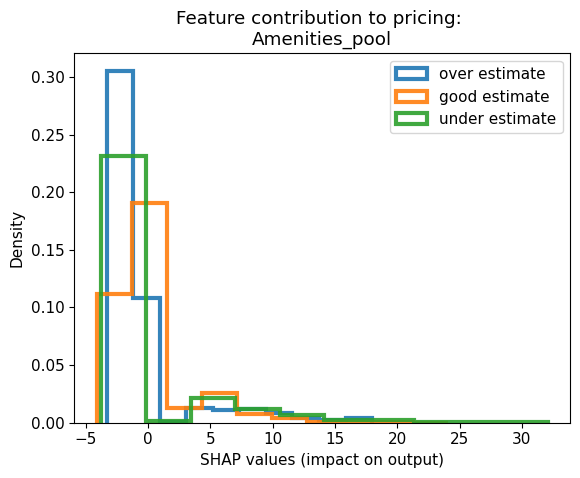

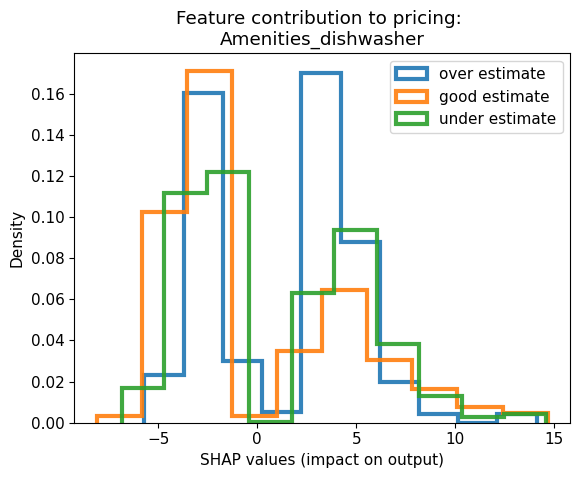

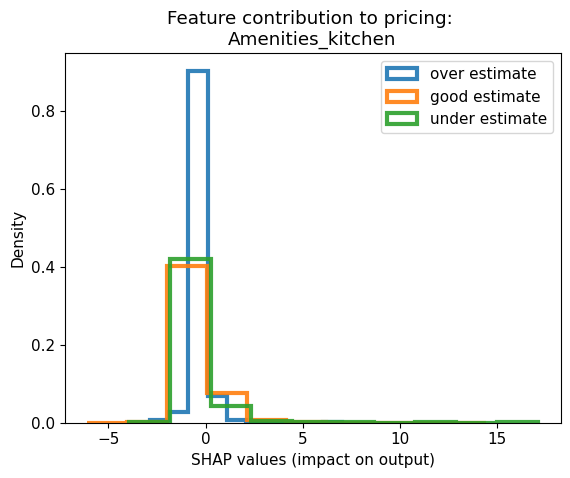

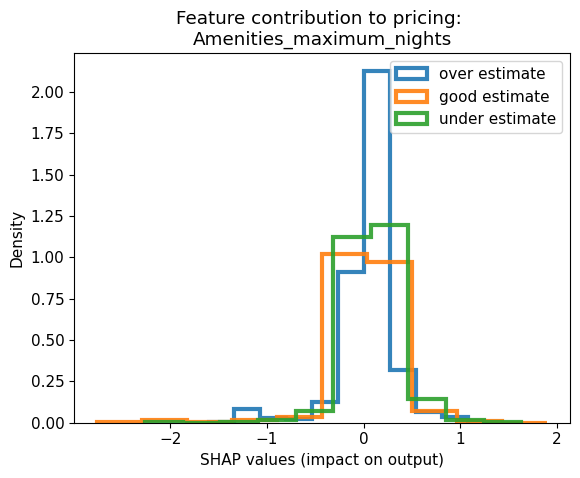

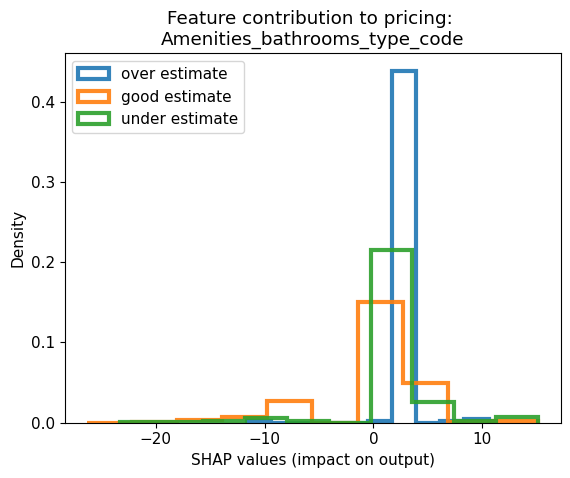

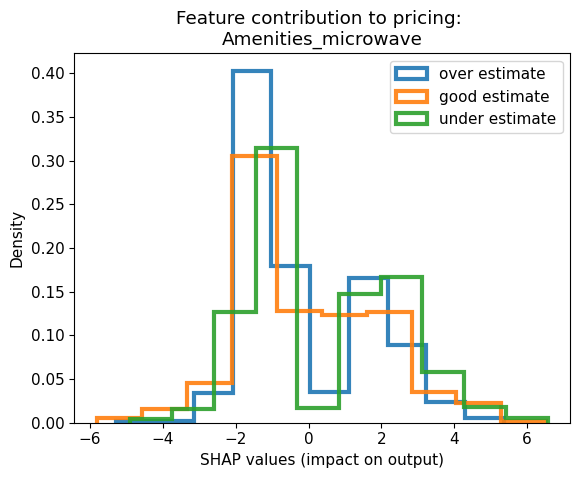

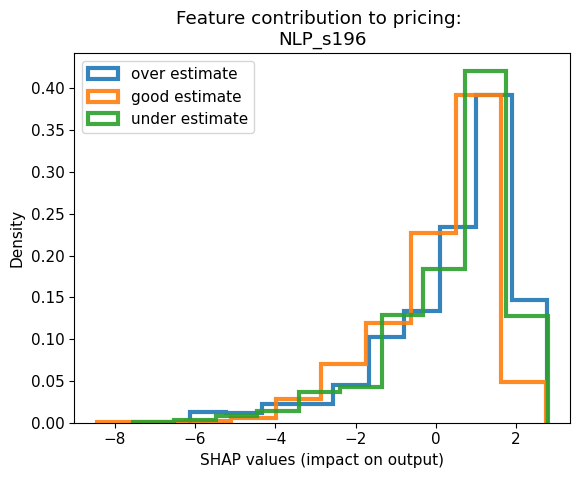

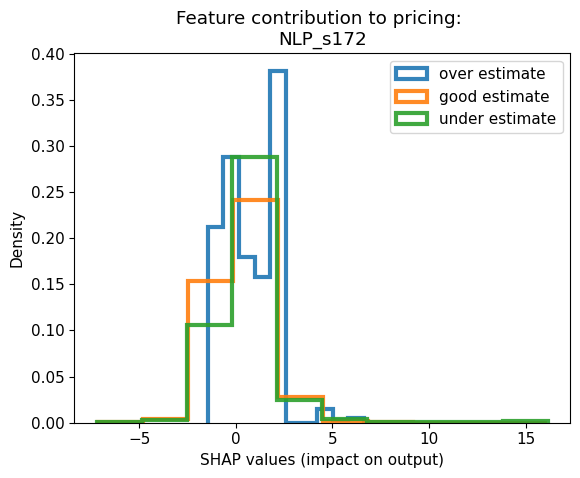

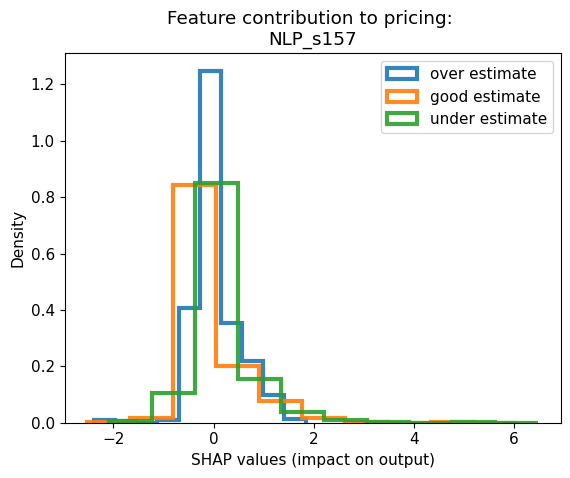

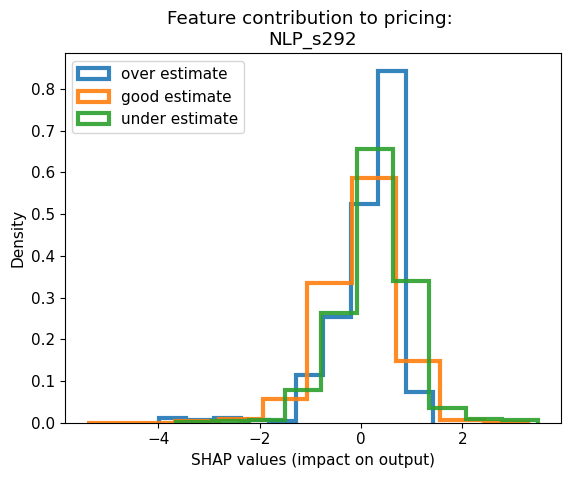

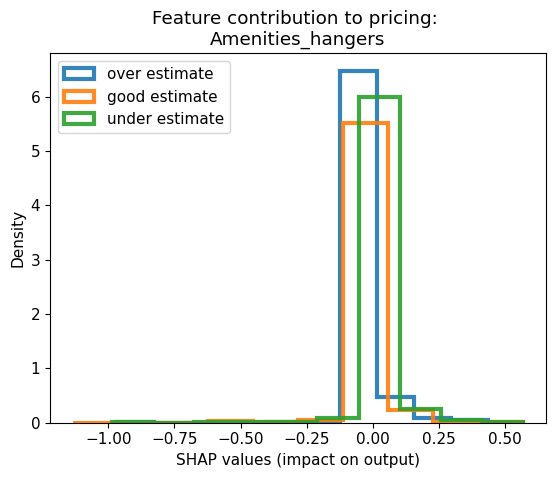

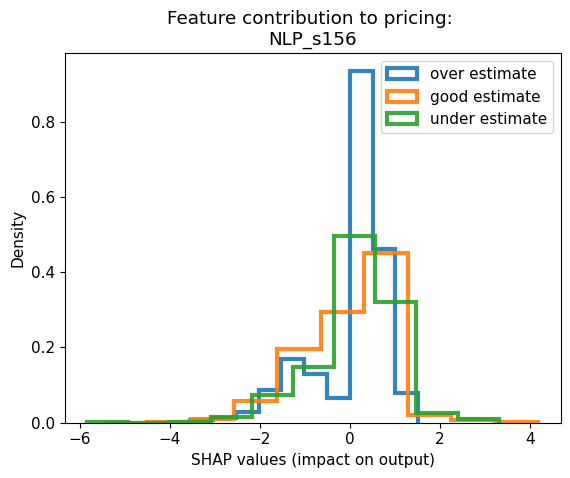

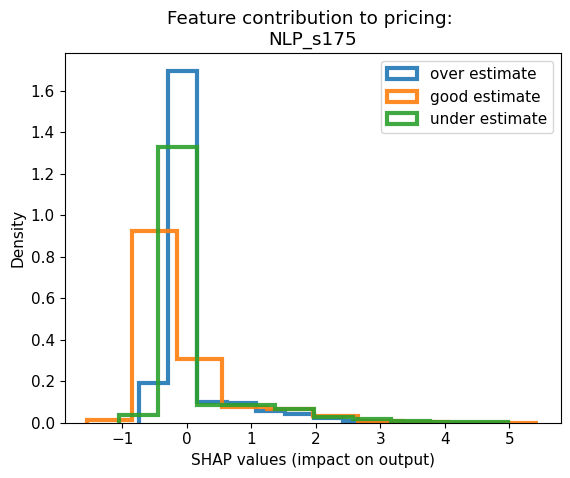

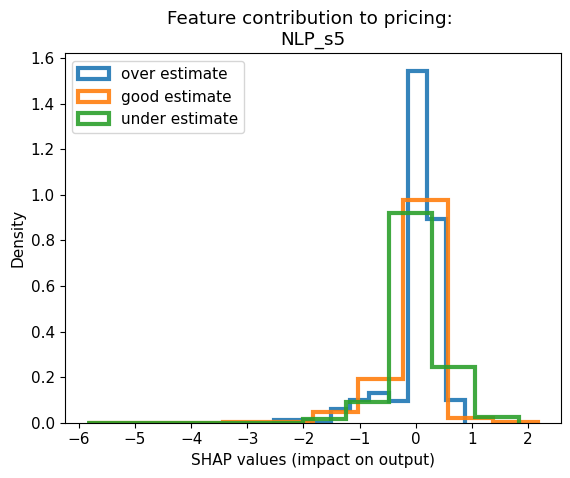

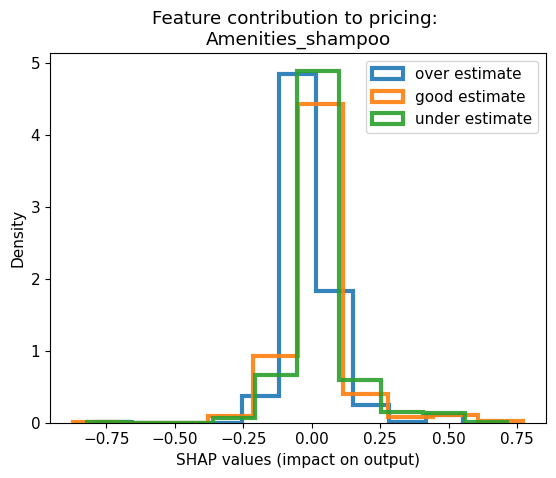

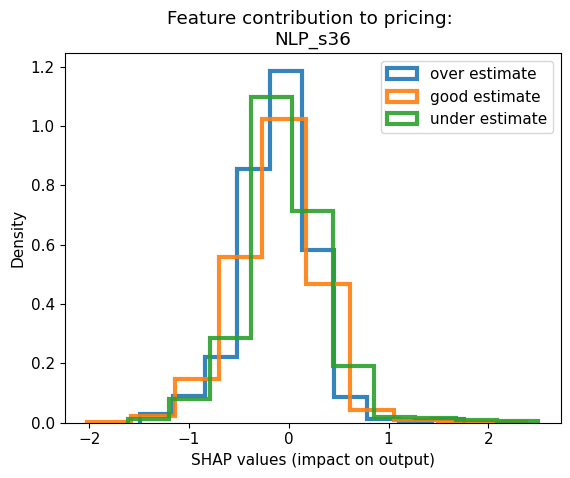

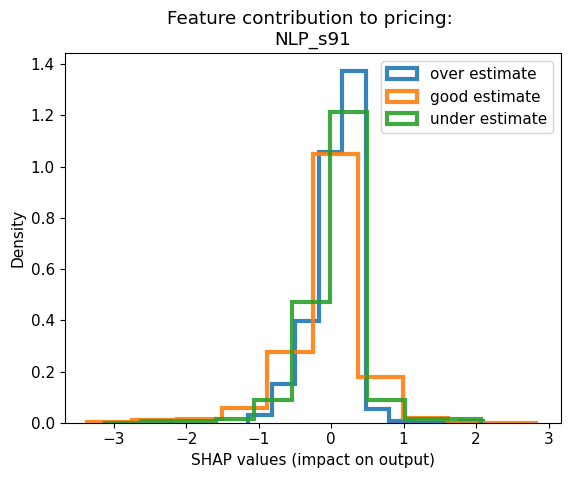

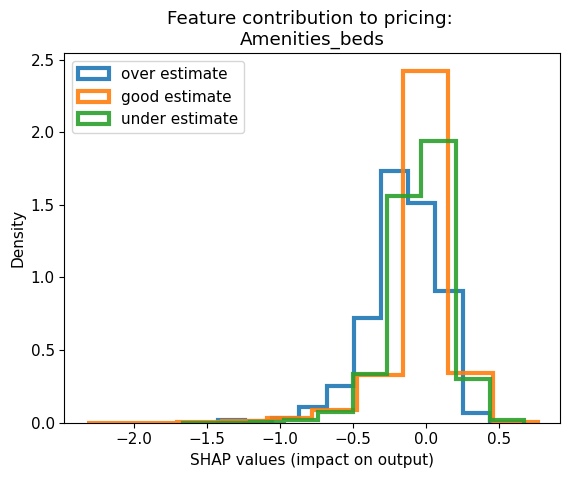

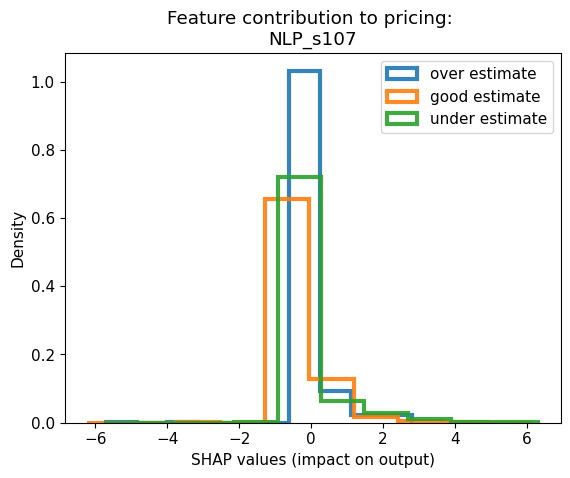

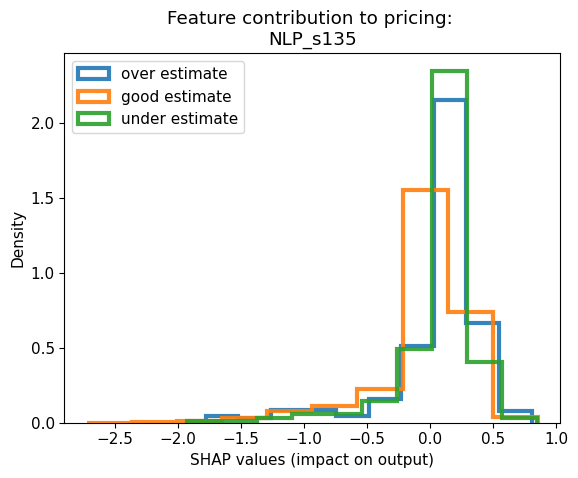

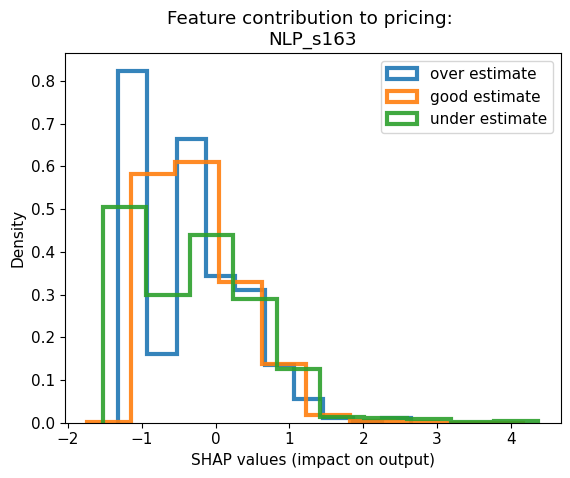

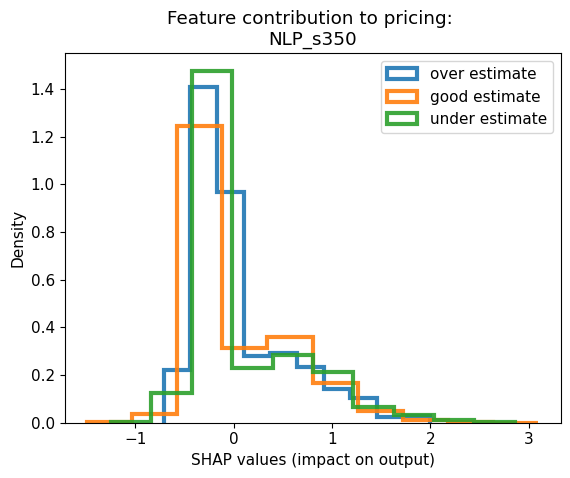

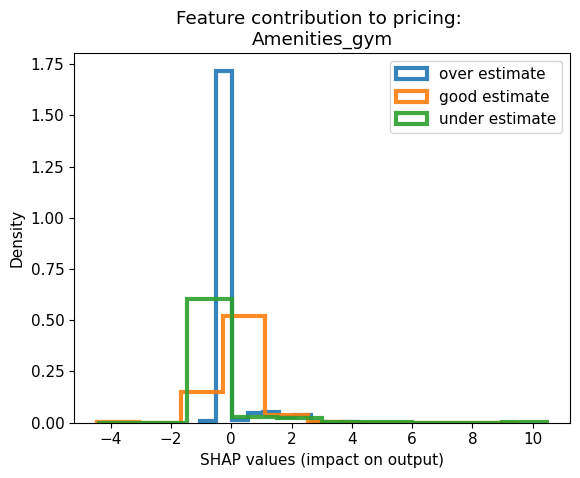

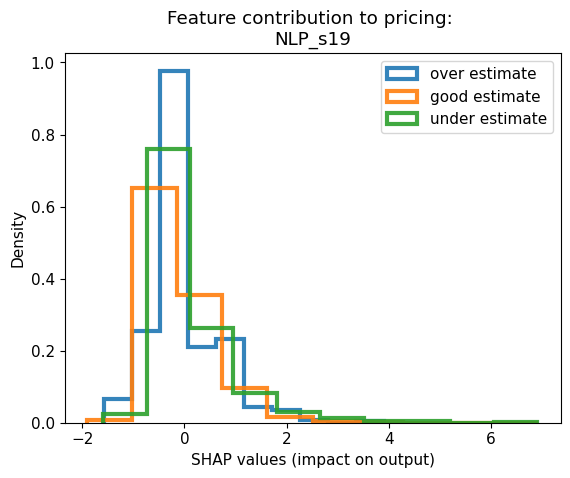

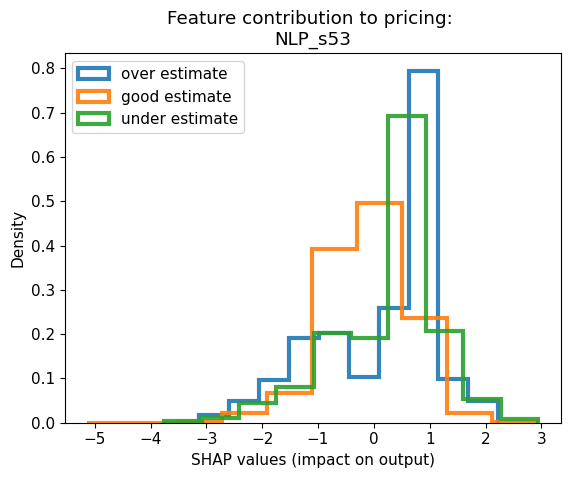

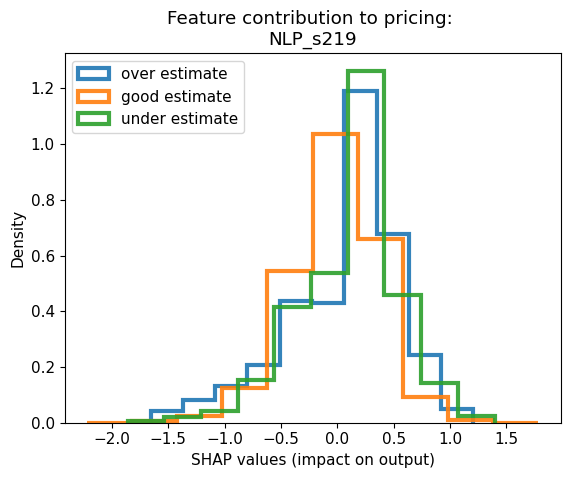

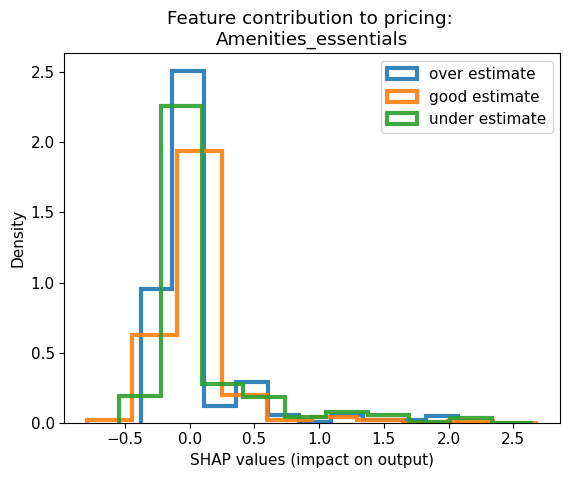

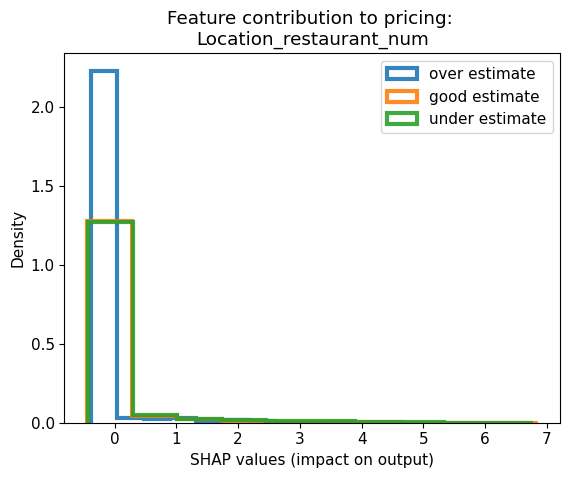

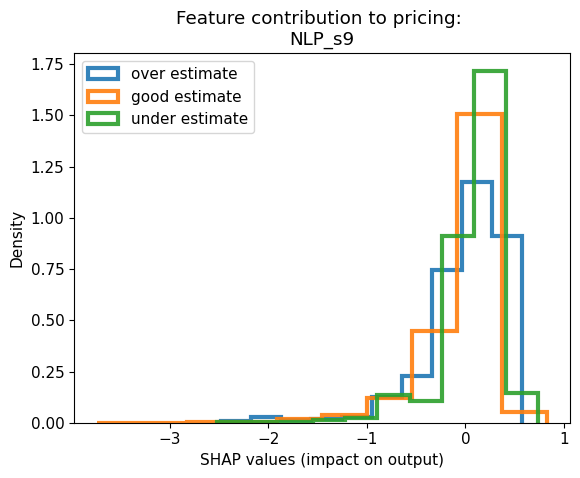

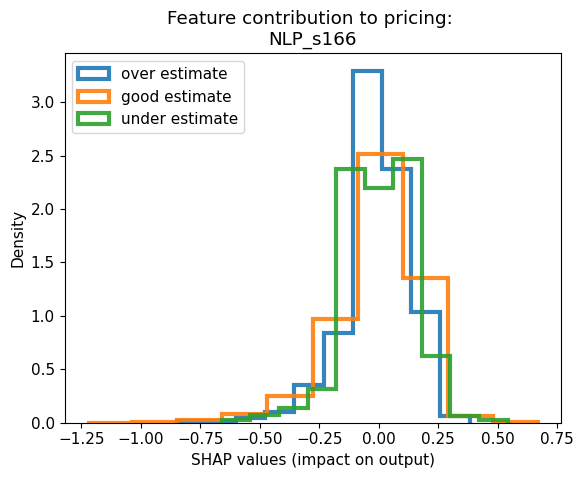

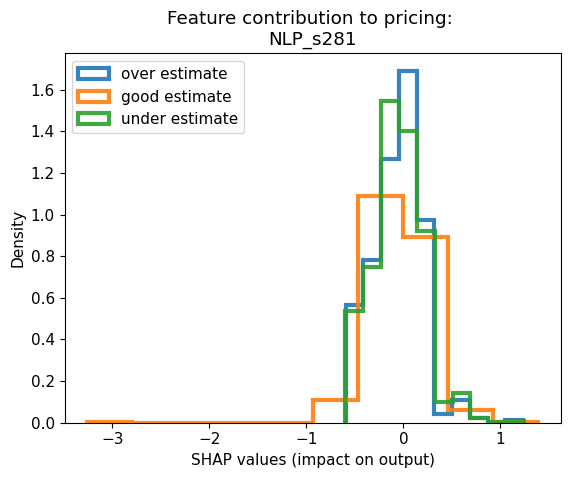

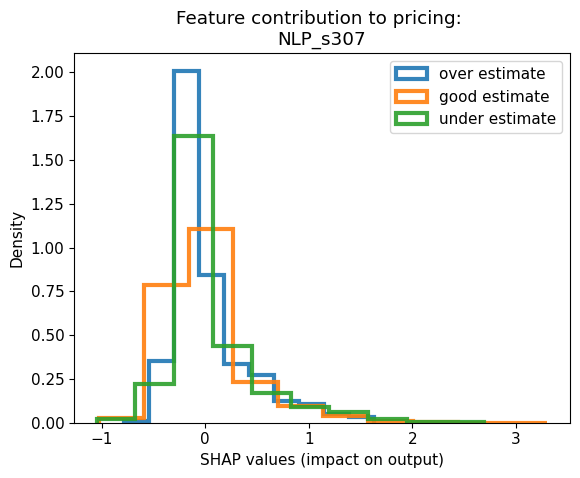

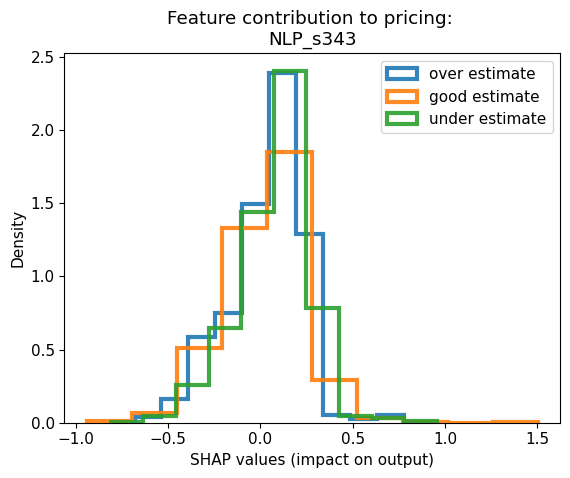

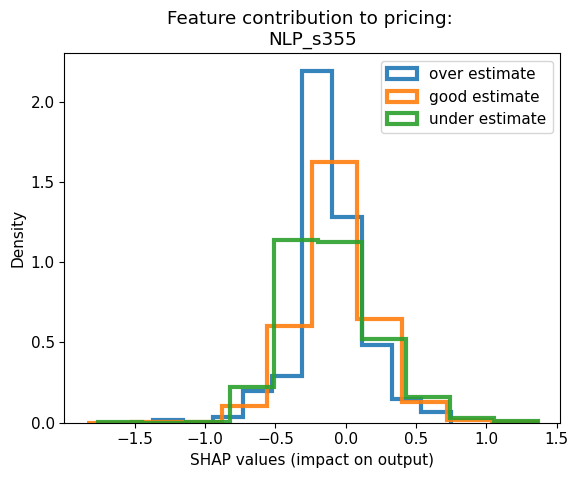

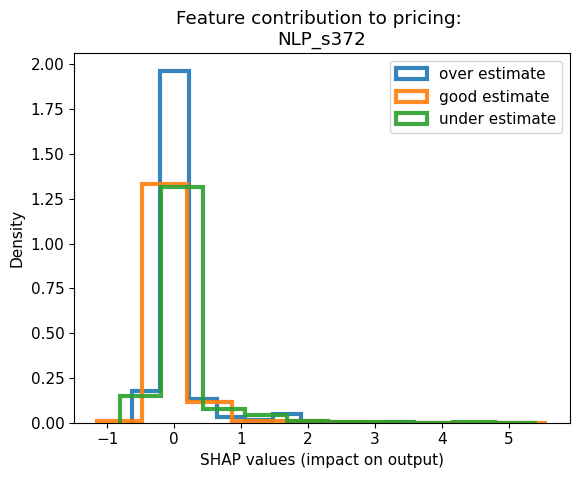

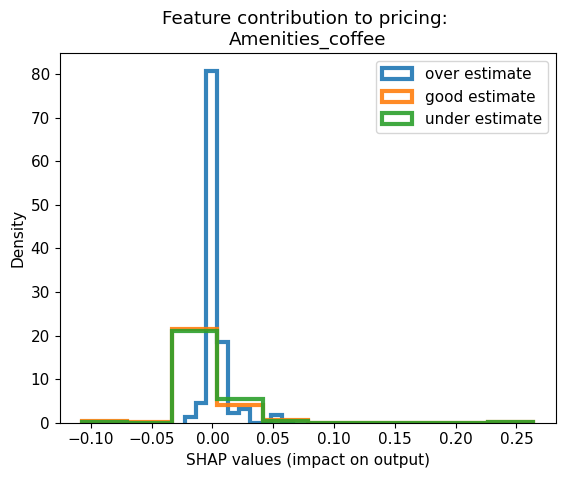

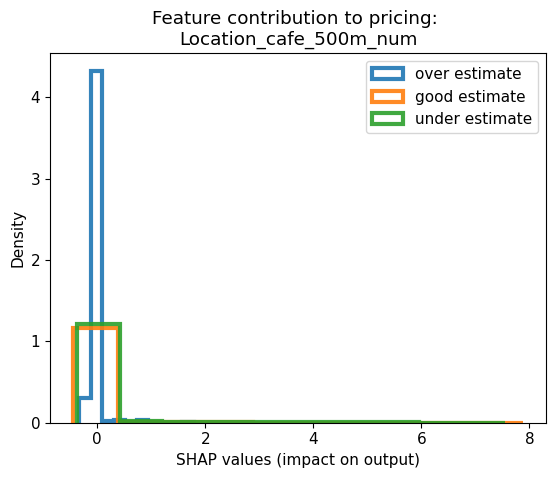

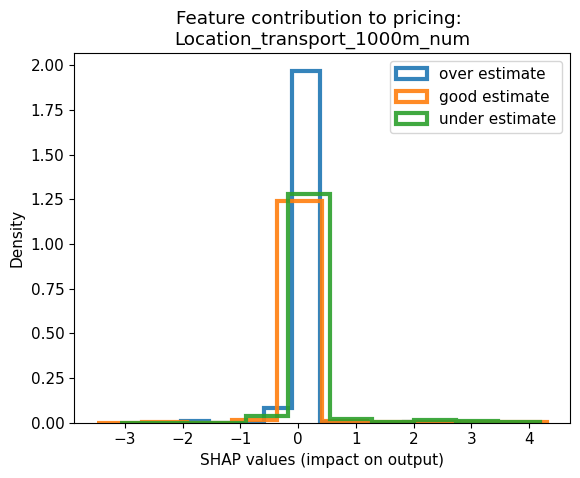

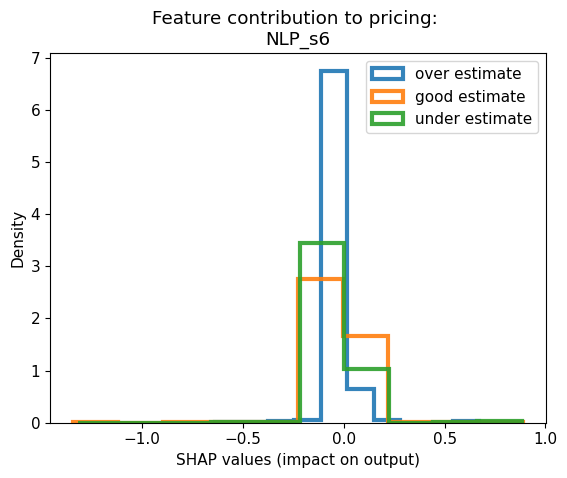

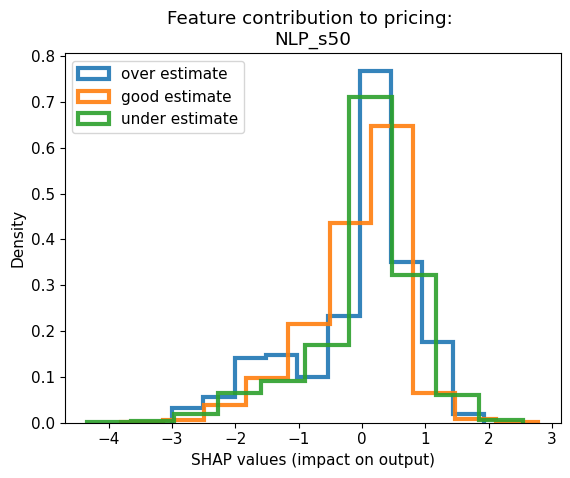

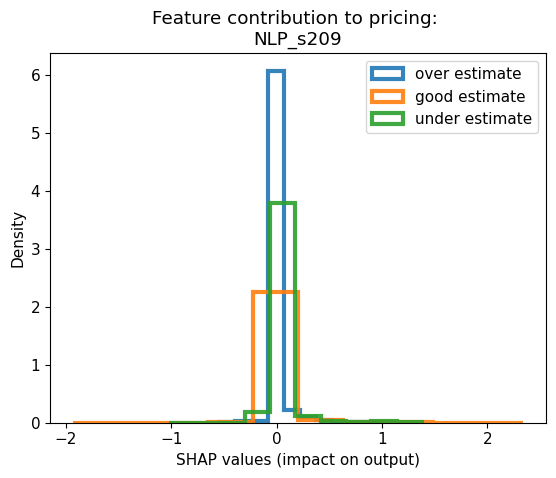

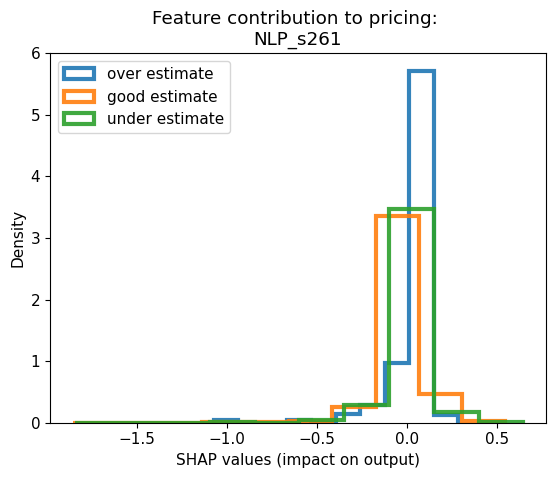

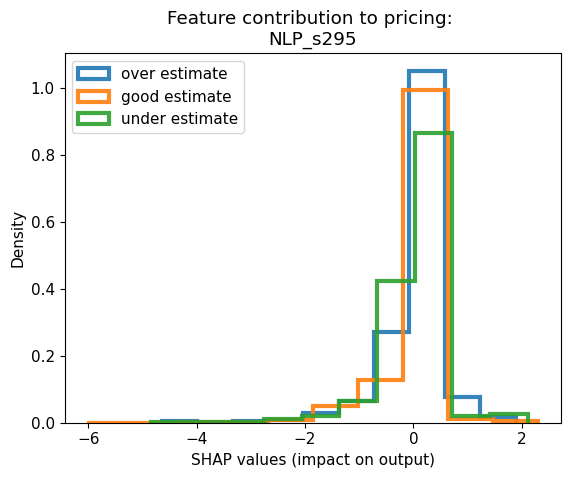

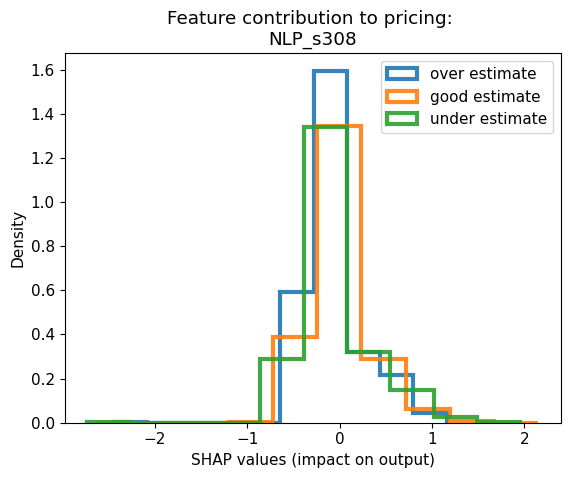

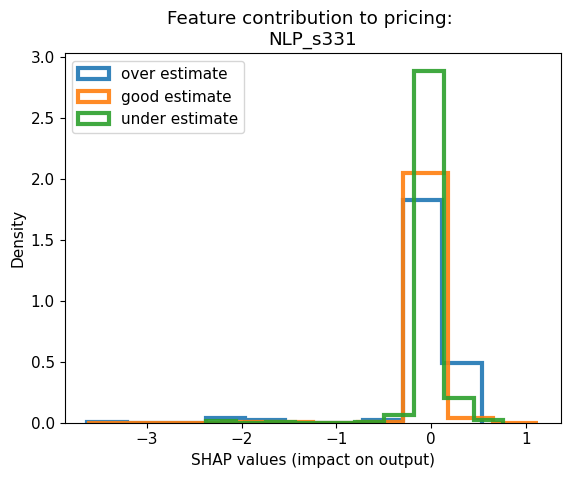

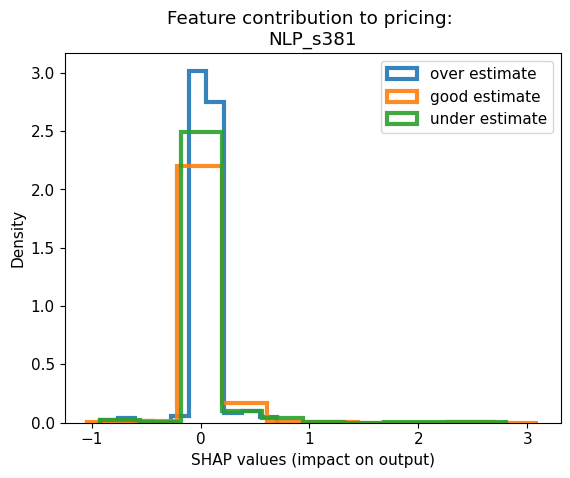

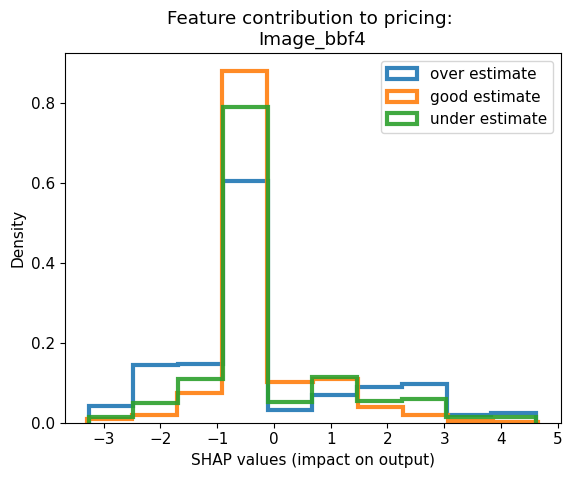

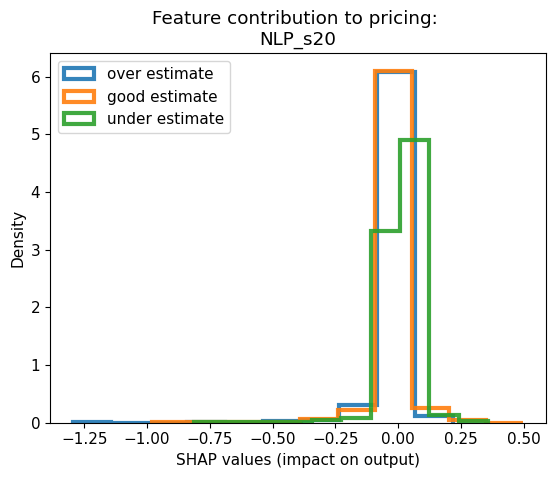

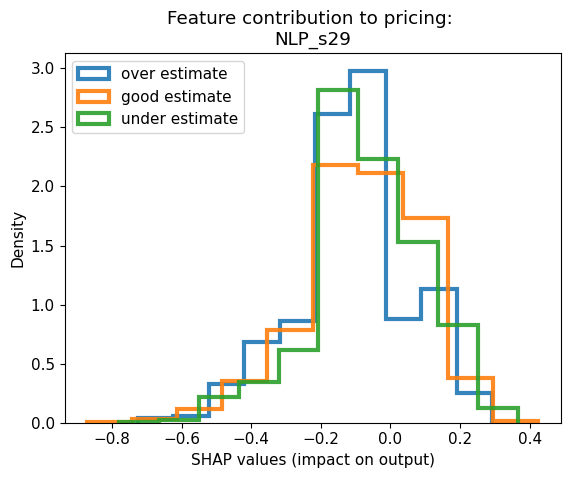

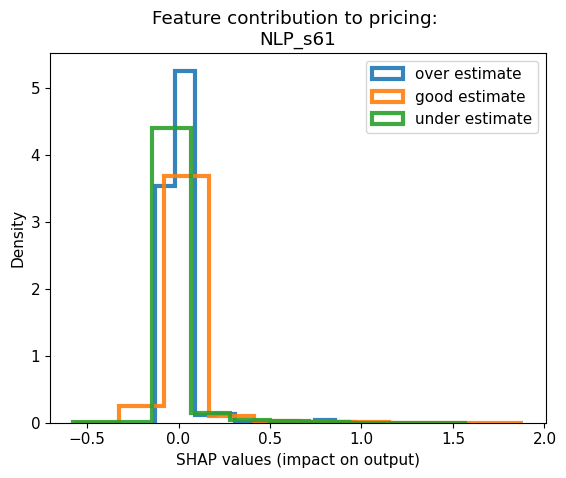

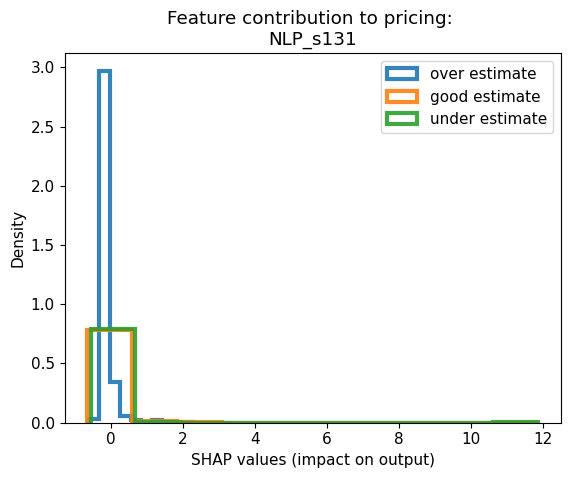

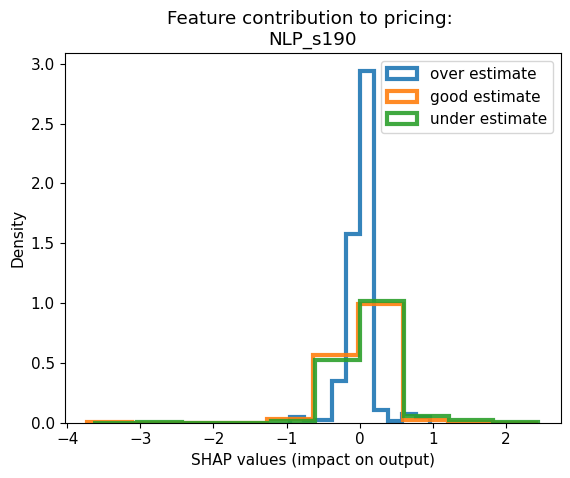

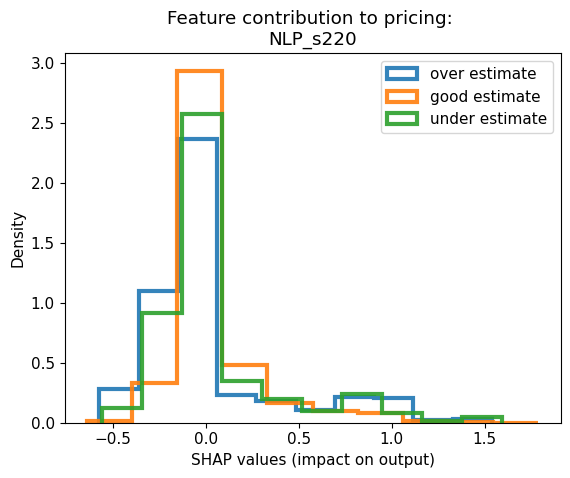

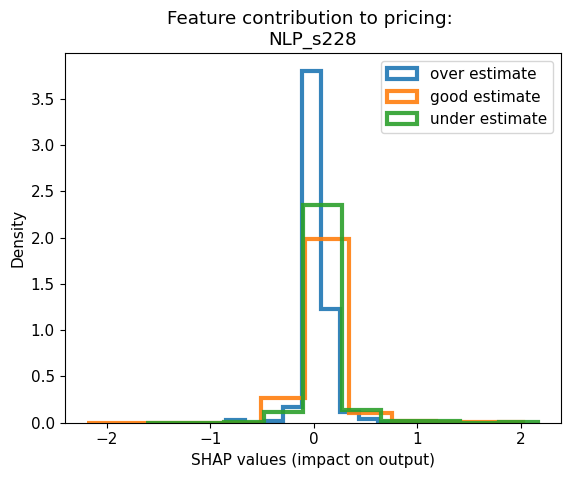

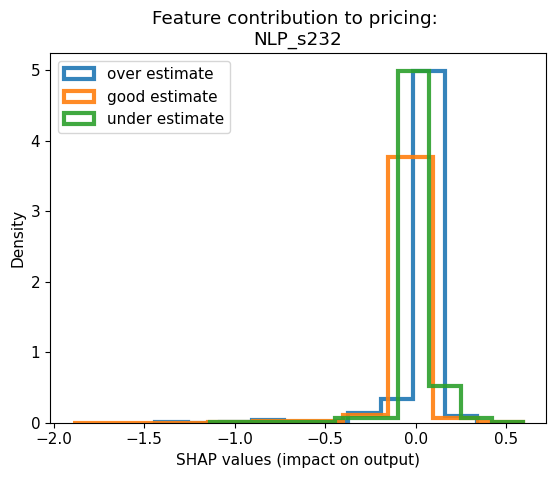

In [154]:
top_20_features = [i[0] for i in 
                   sorted(
    dict(
            zip(
                model.pipeline_dict[0.5][1].feature_name_,
                model.pipeline_dict[0.5][1].feature_importances_
            )
        ).items(), key=lambda x:-x[1]
)[:100]
                   ]
for i in top_20_features:
    try:
        over_ = over_estimate_df.loc[:,i].values
        good_ = good_estimate_df.loc[:,i].values
        under_ = under_estimate_df.loc[:,i].values
        plt.figure()
        plt.hist(over_,label='over estimate',density=True, fill=False, histtype='step',linewidth=3,alpha=0.9)
        plt.hist(good_,label='good estimate',density=True, fill=False, histtype='step',linewidth=3,alpha=0.9)
        plt.hist(under_,label='under estimate',density=True, fill=False, histtype='step',linewidth=3,alpha=0.9)
        plt.title(f'Feature contribution to pricing: \n{i}')
        plt.xlabel('SHAP values (impact on output)')
        plt.ylabel('Density')
        plt.legend()
        plt.savefig(f'./Failure_analysis/{i}.png',dpi=500)
    except:
        continue

In [139]:
[i for i in dir(model.pipeline_dict[0.5][1]) if 'feature' in i.lower()]

['_check_feature_names',
 '_check_n_features',
 '_n_features',
 '_n_features_in',
 'feature_importances_',
 'feature_name_',
 'n_features_',
 'n_features_in_']

[('Amenities_amenities_count', 167),
 ('Location_mean_area_accommodates_price', 164),
 ('Amenities_minimum_nights', 106),
 ('Amenities_property_type_code', 106),
 ('Amenities_bathrooms_count', 46),
 ('Location_real_estate', 43),
 ('NLP_boutique_hostel', 41),
 ('Location_mean_area_beds_price', 40),
 ('Amenities_bedrooms', 39),
 ('Amenities_fire_extinguisher', 32),
 ('Amenities_room_type_code', 30),
 ('Amenities_pool', 28),
 ('Amenities_dishwasher', 25),
 ('Amenities_pets_allowed', 25),
 ('Amenities_kitchen', 24),
 ('Amenities_maximum_nights', 22),
 ('Amenities_bathrooms_type_code', 22),
 ('Amenities_microwave', 21),
 ('Location_Santa_Monica_Pier', 21),
 ('Location_Santa_Monica_Promenade', 21)]

In [115]:
over_estimate_df

,Amenities_bedrooms,Amenities_beds,Amenities_minimum_nights,Amenities_maximum_nights,Amenities_property_type_code,...,Image_teddy bear,Image_hair drier,Image_toothbrush,Image_mean_mean_min_dist_r3,Image_mean_mean_weighted_min_dist_r3
0,40.743773,0.066442,-14.276142,0.054390,25.743603,...,0.0,0.0,0.0,-0.003607,0.000091
1,52.418921,-0.060042,-14.572971,0.111018,3.388915,...,0.0,0.0,0.0,0.004548,-0.000371
2,26.239341,0.103538,18.878863,0.419868,15.381210,...,0.0,0.0,0.0,0.003239,0.000091
3,32.816445,-0.272301,-13.896456,-0.027665,15.879225,...,0.0,0.0,0.0,-0.006861,-0.000371
4,63.865830,-0.229776,12.308594,0.079983,29.003985,...,0.0,0.0,0.0,0.032820,-0.000371
...,...,...,...,...,...,...,...,...,...,...,...
499,35.547004,0.110728,-9.431575,0.037779,12.687759,...,0.0,0.0,0.0,0.008150,0.000091
500,91.835119,-0.080299,-8.031459,0.032117,23.649328,...,0.0,0.0,0.0,0.005826,0.000091
501,64.202923,-0.202863,-11.419112,-0.160755,12.962632,...,0.0,0.0,0.0,0.008150,0.000152
502,46.721641,-0.037952,6.493422,0.131714,-50.659812,...,0.0,0.0,0.0,0.005826,0.000091


In [116]:
good_estimate_df

,Amenities_bedrooms,Amenities_beds,Amenities_minimum_nights,Amenities_maximum_nights,Amenities_property_type_code,...,Image_teddy bear,Image_hair drier,Image_toothbrush,Image_mean_mean_min_dist_r3,Image_mean_mean_weighted_min_dist_r3
0,33.890751,-0.170654,-23.441227,0.049910,6.099256,...,0.0,0.0,0.0,-0.005706,-0.000371
1,-15.230871,0.104948,8.646493,-0.145100,-15.343491,...,0.0,0.0,0.0,0.003080,0.000091
2,-19.658862,0.098475,-6.927385,-0.023544,8.591011,...,0.0,0.0,0.0,0.009017,0.000091
3,-19.974312,0.030693,5.602715,0.090828,5.184107,...,0.0,0.0,0.0,0.005703,0.000091
4,-19.368188,-0.053068,-9.337817,-0.066384,8.511950,...,0.0,0.0,0.0,-0.005025,0.000091
...,...,...,...,...,...,...,...,...,...,...,...
31535,-22.882660,-0.489560,19.600544,0.314037,9.978426,...,0.0,0.0,0.0,0.008150,0.000091
31536,30.356136,0.017075,-13.968363,0.285548,4.582575,...,0.0,0.0,0.0,0.005826,0.000091
31537,28.679328,0.089446,-10.829031,0.053384,13.092028,...,0.0,0.0,0.0,0.008150,0.000091
31538,26.150241,0.086721,9.982162,0.069874,6.902011,...,0.0,0.0,0.0,0.008150,0.000152


In [117]:
under_estimate_df

,Amenities_bedrooms,Amenities_beds,Amenities_minimum_nights,Amenities_maximum_nights,Amenities_property_type_code,...,Image_teddy bear,Image_hair drier,Image_toothbrush,Image_mean_mean_min_dist_r3,Image_mean_mean_weighted_min_dist_r3
0,29.715374,0.339316,-10.804374,-0.174461,-41.180461,...,0.0,0.0,0.0,0.004548,0.000091
1,69.043622,-0.232108,-10.416861,0.021240,24.859896,...,0.0,0.0,0.0,0.009545,0.000091
2,-16.118256,0.148089,11.639769,-0.194597,-24.990917,...,0.0,0.0,0.0,0.004394,0.000091
3,-16.497486,0.479328,5.745695,0.257292,-23.236829,...,0.0,0.0,0.0,0.003239,0.000091
4,-14.767073,-0.020216,4.750572,-0.012362,-18.291207,...,0.0,0.0,0.0,0.003866,0.000091
...,...,...,...,...,...,...,...,...,...,...,...
2778,-20.804329,-0.123824,14.687263,0.021438,7.671427,...,0.0,0.0,0.0,0.005826,0.000091
2779,69.062158,0.040759,15.541096,0.089476,21.402535,...,0.0,0.0,0.0,0.008150,0.000091
2780,69.094563,-0.037312,7.408460,0.135942,16.844707,...,0.0,0.0,0.0,0.005826,0.000091
2781,-19.939217,-0.041861,6.892238,0.239175,-28.385208,...,0.0,0.0,0.0,0.008150,0.000091


In [113]:
np.array(ME<100) & np.array(ME>-100)

array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [111]:
pd.DataFrame(l).mean(axis=0)

Amenities_bedrooms                      49.548087
Amenities_beds                          -0.158601
Amenities_minimum_nights                -0.825631
Amenities_maximum_nights                 0.042097
Amenities_property_type_code            15.539645
                                          ...    
Image_teddy bear                         0.000000
Image_hair drier                         0.000000
Image_toothbrush                         0.000000
Image_mean_mean_min_dist_r3              0.001921
Image_mean_mean_weighted_min_dist_r3     0.000031
Length: 1810, dtype: float64

190.0

[('Amenities_property_type_code', -26.22317977604402),
 ('Amenities_room_type_code', -19.54066614336836),
 ('Amenities_bedrooms', -16.245943255771245),
 ('Location_mean_area_accommodates_price', 14.615570468931903),
 ('Amenities_private hot tub', 9.183419898346273),
 ('Amenities_minimum_nights', 9.113540583668176),
 ('Amenities_bathrooms_count', -6.110837234507704),
 ('Location_real_estate', -5.876508800546601),
 ('Amenities_bathrooms_type_code', 5.458514358234206),
 ('Amenities_bathroom essentials', 3.326162270409282),
 ('NLP_s157', 2.35960667541237),
 ('Location_mean_area_beds_price', -2.330280729060163),
 ('Amenities_dishwasher', -2.258047228542746),
 ('Amenities_microwave', 2.150071520609258),
 ('Location_Angeles Stadium', 2.0254360641332934),
 ('NLP_s172', -1.65869442647154),
 ('NLP_s292', 1.33212891662181),
 ('Amenities_pets allowed', -1.203971566705122),
 ('Amenities_outdoor dining area', -1.0591683522409667),
 ('Amenities_pool', -0.922290329154705),
 ('Amenities_bbq grill', -0.

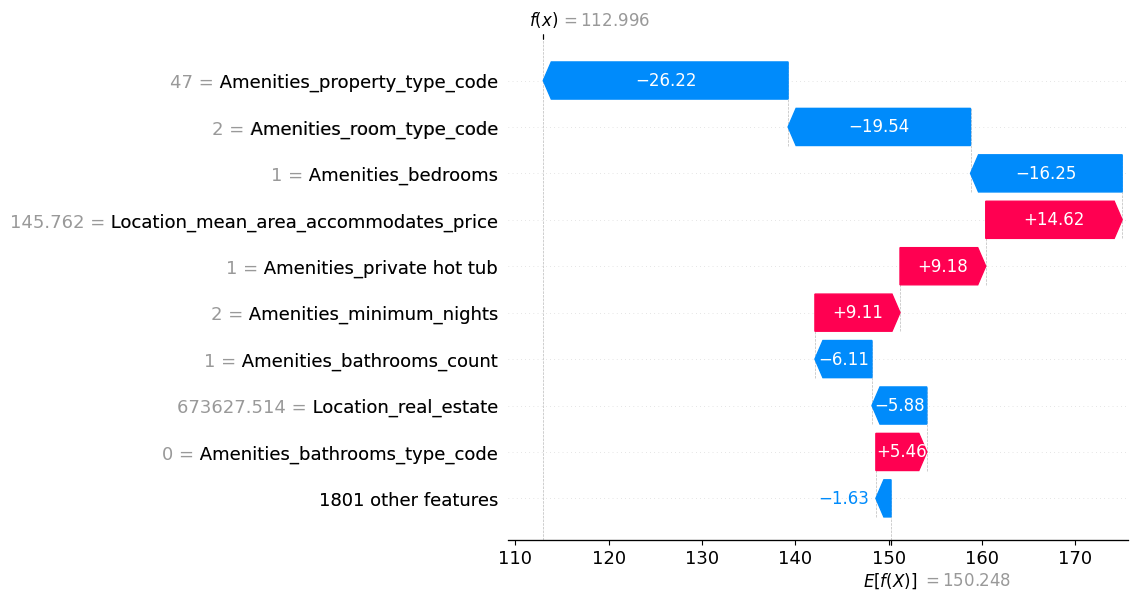

In [92]:
shap.plots.waterfall(shap_values[1], matplotlib=True)

In [66]:
initjs()

NameError: name 'initjs' is not defined

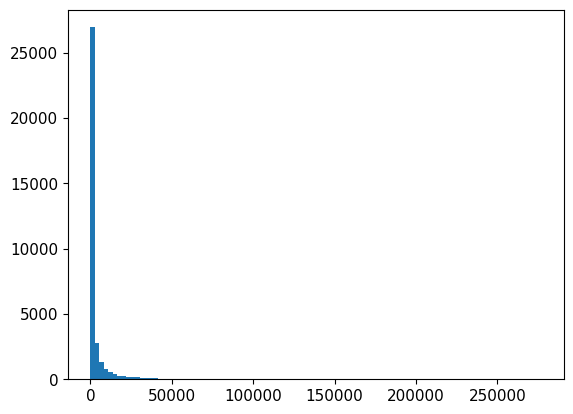

In [45]:
plt.hist((pred[0.5] - y)**2,bins=100)
plt.show()

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings

from Generating_Feature_Importance_tuning_PCA_model import PCA_My_Airbnb_Capstone_Model, PCA_pre_processing_pipeline
from Generating_Feature_Importance_tuning_raw_feature_model import My_Airbnb_Capstone_Model, pre_processing_pipeline
from scipy.stats import spearmanr



In [3]:
### read features
data = pd.read_csv('./final_features/LA_extracted_all_features_imputed.csv')
data = data[
    (np.log(data['price']+1)>=sorted(np.log(data['price']+1))[int(0.025*len(data))]) &\
    (np.log(data['price']+1)<=sorted(np.log(data['price']+1))[int(0.975*len(data))])
    ] ### remove outliers




In [20]:
### define model
model = My_Airbnb_Capstone_Model()
### get X,y
X, y = model.get_X_y(data)
del data
### training
model.train(X, y, tuning=False)



Filling infinite values with -1 ...

Amenities raw features count: 174
Location raw features count: 28
Image raw features count: 617
NLP raw features count: 994


X shape: (34827, 1813)
y shape: (34827,)



Training quantile models: 100%|██████████| 5/5 [07:06<00:00, 85.32s/it]


KeyError: 0.5

In [11]:
from sklearn.metrics import r2_score
pred_dict = model.predict(X[model.x_names])
r2_score(
    pred_dict[0.5],
    y
)

KeyboardInterrupt: 

In [8]:
model.scores

{}

In [24]:

model.train(X, y, tuning=False, sample_weight=True)


TypeError: train() got an unexpected keyword argument 'sample_weight'

In [ ]:
(y+1)**(1/2)